# MLLib Development Notes

Reverse time order - Newest on top

21 January 2023
- Now it switches between train and test without allocating more memory.  
- the change is moving outputs = model(inputs) into with dorch.no_grad() scope:
    ```python
    with torch.no_grad():
        data = next(iTest)
        inputs, labels = data

        if args.cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()

        #with torch.cuda.amp.autocast():
        outputs = model(inputs)
        loss, cross_entropy_loss, architecture_loss, architecture_reduction, cell_weights, prune_loss, sigmoid_scale = loss_fcn(outputs, labels, model)
        classifications = torch.argmax(outputs, 1)
        top1_correct = (classifications == labels).float()
        test_accuracy = torch.sum(top1_correct)/len(top1_correct)
    ```

20 January 2023
- Merging pytorch imagenet training algorithm into cell2d.py
- Model re-allocates model between test and training batch in Train()
- This results in out of memory errors for large batches
- What triggers model data to be allocated a second time?

10 November 2022
- Build plot from multiple runs.
- First step of cityscapescrisp-l9fl7 looks good

5 Nobember
- Can now initialize Resnet 18, 35, 50, 101, and 152 from pyorch
- Automatically initializes based on the choice
- Only initialize matching layers
- Can handel with and without conv1
Imagenet 152
- crispimagnent_20221104_232354_ai2 
- job crispimagenet-s7mxf
- batch_size 75 because something was causing out of memory at startup.
- I think it is now running on AI3, GPU 0 wtih 51267 MB GPU memory
- I set learning rate to 1e-4, k_accuracy = 1, k_structure 0.2, k_prune_basis = 5.0.  I think that is high for k_prune_bais.  Epochs=20, ejector_start=9, ejector_full=1-.
- After 14k samples, architecture_redution is 95%.  I think this is limited by the learning rate.  
I expect a larger learning rate would reduce the accuracy beyond you can restore without cutmix and other training sequences that I haven't implemented.
- I started a similar run on hiocnn but it failed to initialize from pretrained resnet.  Why?
CIFAR10
- Start with imagenet pretrained
- Shortened the initial training too much.
- Try a few short runs to see how to get the best CIFAR-10 accuracy from pretrained resnet.
- 


3 November
CIFAR 10
- 2 runs with the following parameters
    ```yaml
    - {name: ejector_start, value: 24}
    - {name: ejector_full, value: 25}
    - {name: ejector_max, value: 1.0}
    - {name: k_accuracy, value: 1.0}
    - {name: k_structure, value: 0.3}
    - {name: k_prune_basis, value: 1.0}
    - {name: learning_rate, value: 1e-3}
    - {name: learning_rate_decay, value: 0.25}
    - {name: rate_schedule, value: "[20, 30, 40, 45, 48]"}
    ```
- Final results crispcifar10-j6598
    ```yaml
    "prune": {
        "final parameters": 1472196,
        "initial parameters": 11144978,
        "remaining ratio": 0.13209501176224844,
        "final flops": 519159872.0,
        "initial flops": 2081330186.0,
        "remaining flops": 0.24943657450034215
    },
    "test": {
        "accuracy": 0.9104,
        "minimum time": 0.00018616,
        "average time": 0.00022547190000000002,
        "num images": 10000
    }
    ```
- Final results crispcifar10-7hzbv
    ```yaml
    "prune": {
    "final parameters": 1158295,
    "initial parameters": 11144978,
    "remaining ratio": 0.10392976998249795,
    "final flops": 392450690.0,
    "initial flops": 2081330186.0,
    "remaining flops": 0.18855763138391343
  },
  "test": {
    "accuracy": 0.9081,
    "minimum time": 0.00017398,
    "average time": 0.00017570680000000003,
    "num images": 10000
  }
- Test k_structure 0.5 to see if these maintain accuracy: crispcifar10-hk4p9, 20221103_083925_ipc001
- Test k_structure 0.7 to see if these maintain accuracy: 

Cityscapes
- 2 completed runs
- cityscapescrisp-7z2hd, crispcityscapes_20221102_173821_hiocnn
    - name: k_structure value: 0.3
    - Final miou: 0.3409290518484971
    - Final flops:
      ```yaml
      "prune": {
      "final parameters": 9483951,
      "initial parameters": 31039057,
      "remaining ratio": 0.305548941129236,
      "final flops": 50761052160.0,
      "initial flops": 218911211520.0,
      "remaining flops": 0.23187963653182928
      },
      ```
    - Unique accuracy divergence in searc_structure_04
    - No significant change in prune_weights
    - Not enough prune weights in play for effective pruning.  Most already solid red or blue
    - Nothing else really happing at point that cross_entropy_loss diverged - step 33,000
- cityscapescrisp-fdbm6, crispcityscapes_20221102_173841_hiocnn
  - name: k_structure value: 0.1
  - Final miou: 0.6625339287796528
  - Final flops:
    ```yaml
    "prune": {
    "final parameters": 1591184,
    "initial parameters": 31039057,
    "remaining ratio": 0.05126392854009708,
    "final flops": 11552055296.0,
    "initial flops": 218911211520.0,
    "remaining flops": 0.05277050552042918
  },
  ```
- This run was almost everything I could have wanted
- I would have wanted MIOU over 7 but it looks like it could have achieved this with more time
Next test:
- k_structure value: 0.1
- k_prune_basis value: 0.3
- Increase epochs




2 November 2022
CIFAR10
- [cifar10crisp_20221101_184447_ipc001](../test/cifar10crisp_20221101_184447_ipc001.yaml) successfully converged to 90% sparsity while maintaining test accuracy
- Smooth, convergence
- Prune loss always on
- Good separation between on/off weights
    ![](../img/cifar10crisp_20221101_184447_ipc001.png)
    ![](../img/cifar10crisp_20221101_184447_ipc001_cw.png)
- Can more agressive pruning still maintain accuracy?
- Try cyling prune loss on and off
Cityscapes
- [cityscapescrisp_20221101_191519_hiocnn](../test/cityscapescrisp_20221101_191519_hiocnn.yaml) Poor sepration betweeen on and off
- Contuned to erode model while accuracy decreased
    ![](../img/cityscapescrisp_20221101_191519_hiocnn_tb.png)
    ![](../img/cityscapescrisp_20221101_191519_hiocnn_cw.png)
- Are prune weights being initialzed to 1.0 or 0.5?
- the following resulting no architecture reduction.  It started going down but then got pushed back up by the other losses.
```yaml
        - name: ejector_start
          value: -1
        - name: ejector_full
          value: 0
        - name: ejector_max
          value: 1.0
        - name: model_src
          value: ''
        - name: model_dest
          value: crispcityscapes_{{workflow.parameters.output_name}}
        - name: k_accuracy
          value: 1.0
        - name: k_structure
          value: 0.1
        - name: k_prune_basis
          value: 1.0
        - name: learning_rate
          value: 2e-3

```
- Test k_structure: 0.3
```yaml
            - {name: ejector_start, value: 24}
            - {name: ejector_full, value: 25}
            - {name: ejector_max, value: 1.0}
            - {name: model_src, value: ""}
            - {name: model_dest, value: "crispcifar10_{{workflow.parameters.output_name}}"}
            - {name: k_accuracy, value: 1.0}
            - {name: k_structure, value: 0.3}
            - {name: k_prune_basis, value: 1.0}
            - {name: learning_rate, value: 1e-3}
```
- Test k_structure: 0.1
```yaml
            - {name: ejector_start, value: 24}
            - {name: ejector_full, value: 25}
            - {name: ejector_max, value: 1.0}
            - {name: model_src, value: ""}
            - {name: model_dest, value: "crispcifar10_{{workflow.parameters.output_name}}"}
            - {name: k_accuracy, value: 1.0}
            - {name: k_structure, value: 0.1}
            - {name: k_prune_basis, value: 1.0}
            - {name: learning_rate, value: 1e-3}
```yaml






1 November 2022
- crispcityscapes_20221101_135120_hiocnn_tb prune weights all blue.  MIOU 0.66.  
    - {name: k_accuracy, value: 1.0}
    - {name: k_structure, value: 0.5}
    - {name: k_prune_basis, value: 0.25}
- Next test: k_structure from 0.5 to 0.1 because prune_weights almost completely blue.  Raise k_prune_basis from 0.25 to 1.0 for same reason
- Match state_dict from loaded torchvision to crisp model.state_dict

24 October 2022

| Server | Workflow | Image | Job | Tensorboard | Purpose | Result |
| --- | --- | --- | --- | --- | --- | --- |
| ai3 | imagenetcrispbase.yaml | crisptrain:0.1.143 | [crispimagenet-266v9](https://10.45.1.87:30992/workflows/tr/crispimagenet-266v9?tab=workflow) | [crispimagenet_20221023_211808_ai3_tb] | Train resnet 50 on imagenet for intro plot |
| hiocnn | cityscapes.yaml | crisptrain:0.1.143 | [cityscapescrisp-kc7sh](https://192.168.0.163:30992/workflows/ml/cityscapescrisp-kc7sh?tab=workflow&nodeId=cityscapescrisp-kc7sh-1817027528&nodePanelView=inputs-outputs) | [crispcityscapes_20221023_000504_hiocnn_tb] | Train resnet 50 on imagenet for intro plot | Everyting is nothing |
| hiocnn | cityscapes.yaml | localhost:32000/crispdev:0.1.144 | [cityscapescrisp-cp759](https://192.168.0.163:30992/workflows/ml/cityscapescrisp-cp759) | [crispcityscapes_20221024_064430_hiocnn_tb](http://hiocnn:6006/) | Cityscapes training for paper.  Initially train without weights. |  |
| hiocnn | cityscapescrispss.yaml | localhost:32000/crispdev:0.1.144 | [cityscapescrisp-tzj28](https://192.168.0.163:30992/workflows/ml/cityscapescrisp-q8flp) | [crispcityscapes_20221024_064437_hiocnn_tb](http://hiocnn:6007/) | Cityscapes single step training for paper.  Initially train without weights. |  |
| ipc001 | cifar10crisp.yaml | localhost:32000/crispdev:0.1.143 | [crispcifar10-kh7wt](https://192.168.0.155:30992/workflows/ml/crispcifar10-kh7wt) | [crispcifar10_20221022_224910_ipc001_tb](http://hiocnn:6007/) | Train with initial training based on crispcifar10_20221022_224910_ipc001_tb. |  |
| ipc001 | workflow/cifar10.yaml | localhost:32000/crispdev:0.1.143 | ["crispcifar10-sqd4l](https://192.168.0.155:30992/workflows/ml/"crispcifar10-sqd4l) | [crispcifar10_20221024_095159_ipc001_tb]() | Train Resnet 56 CIFAR model with extended initial training based on crispcifar10_20221022_224910_ipc001_tb. |  |
| ai2 |cifar10crisp.yaml | sci-ai-docker-internal.ha-us.dso.thermofisher.net/crispdev:0.1.143 | [crispcifar10-hrgp9](https://192.168.0.155:30992/workflows/ml/crispcifar10-hrgp9) | [crispcifar20221024_100353_ai2_tb]() | Train Resnet 56 CIFAR model with extended initial training based on crispcifar10_20221022_224910_ipc001_tb. |  |

22 October 2022

| Server | Workflow | Job | Tensorboard | Purpose | Result |
| --- | --- | --- | --- | --- | --- |
| HIOCNN | cityscapes.yaml | [cityscapescrisp-5tz88](https://192.168.0.163:30992/workflows/ml/cityscapescrisp-5tz88?tab=workflow) | [crispcityscapes_20221022_200725_hiocnn_tb](http://192.168.0.163:6006/) | Standard training for paper results | Stalled pulling image from dsofrog |
| HIOCNN | cityscapescrisp.yaml | [cityscapescrisp-5qsjm](https://192.168.0.163:30992/workflows/ml/cityscapescrisp-5qsjm?tab=workflow&nodeId=cityscapescrisp-5qsjm-2684523045) | [crispcityscapes_20221022_202621_hiocnn_tb](http://192.168.0.163:6007/) | CRISP multi-step training for paper resiults | Stalled pulling image from dsofrog |
| AI3 | cityscapescrispss.yaml | [cityscapescrisp-xx9c7](https://10.45.1.87:30992/workflows/tr/cityscapescrisp-xx9c7?tab=workflow) | [crispcityscapes_20221022_204948_ai3_tb](http://localhost:6006/) | CRISP single-step training for paper results |
| IPC001 |  cifar10.yaml | [crispcifar10-82rjt](https://192.168.0.155:30992/workflows/ml/crispcifar10-82rjt?tab=workflow) | [crispcifar10_20221022_224314_ipc001_tb](http://ipc001:6012/) | Test Resnet-56 Cifar-10 results | accuracy: 0.917 |
| IPC001 | cifar10.yaml | [crispcifar10-7ljc9](https://192.168.0.155:30992/workflows/ml/crispcifar10-7ljc9?tab=workflow) | crispcifar10_20221022_224910_ipc001_tb | Extend CIFAR-10 Renet 18 initial training ot 40 epochs | accuracy: 0.9158 | 
| IPC001 | cifar10.yaml | [crispcifar10-qwwbj](https://192.168.0.155:30992/workflows/ml/crispcifar10-qwwbj?tab=workflow) | | Extend CIFAR-10 Renet 34 initial training ot 40 epochs | accuracy": 0.9154 |
| IPC001 | cifar10.yaml | [crispcifar10-2vfl](https://192.168.0.155:30992/workflows/ml/crispcifar10-2vfll?tab=workflow) | | Extend CIFAR-10 Renet 56 sgd training | accuracy: 0.8219 |

In [ ]:
19 October 2022

Collapse pentality function
- Max of sigmoid scalied prune weights
- If max prune weight drops below 0.5, max conv_weight becomes 1.0-max
- Add to architecture weight

18 October 2022

Copmpleted all items from 6 October list except graphs
1. Write models to S3 every epoch (done)
1. Incorperate Bishal's class weightings
1. Enable penality function to keep initial and final unet convolutions from collapsing
1. Prepare graphs of training stability for paper
1. Single vs multi-step pruning graphic

6 October 2022
Complted the folloing:
1. Noise augmentation not working for CIFAR tests because the parameters were not passed correctly.  In cifar10store and iamgenetstore.  Now randomly select noise level from 0 to augment_noise and then apply this value as the scale factor for a random tensor:
```python
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        rand_std = random.uniform(0, self.std)
        return tensor + torch.randn(tensor.size()) * rand_std + self.mean
```
1. Fully pruning operators - Why did full collapse not occur in Resnet? - Now seeting channel size to 0 and then collapsing ConvBR based on this.
1. Accurate FLOPS counter: needed correct convolution size  from prevous step to comptue this correctly.  

Next:
1. Explore initializing relaxation variables to a small distribuiton about 0.  This should eliminate the need to delay k_prune_basis.  When I set k_structure and k_prune_basis to 0 initially, the optimzier has been pushing the relaxation variables to 0 for some reason.
1. Correct convolution number of parameters with input size
1. Segmentation statistics package
1. Incrase frequency of infrequent classes in Cityscapes training
1. Full paper edit
1. Prepare graphs of training stability for paper
1. Single vs multi-step pruning graphic
1. Cifar training with dropout
1. Cifar training with noise

5 October 2022

Why is cityscapes MIOU of full dataset plateauing at ~ 40%?
Test similarity of crispcityscapes_20221003_183915_hiocnn0_search_structure_05:
```yaml
    "similarity": {
      "0": {
        "intersection": 7246949,
        "union": 14915080,
        "similarity": 0.4858806657423225
      },
      "1": {
        "intersection": 3,
        "union": 3748718,
        "similarity": 8.002735868635625e-07
      },
      "2": {
        "intersection": 78862687,
        "union": 90035956,
        "similarity": 0.8759021451385489
      },
      "3": {
        "intersection": 6547099,
        "union": 12705750,
        "similarity": 0.5152863073805167
      },
      "4": {
        "intersection": 2398,
        "union": 807556,
        "similarity": 0.0029694535115830974
      },
      "5": {
        "intersection": 0,
        "union": 243128,
        "similarity": 0.0
      },
      "6": {
        "intersection": 25223002,
        "union": 40450349,
        "similarity": 0.6235546200108187
      },
      "7": {
        "intersection": 1385,
        "union": 1274649,
        "similarity": 0.001086573637134615
      },
      "8": {
        "intersection": 7045,
        "union": 1594836,
        "similarity": 0.004417382100730107
      },
      "9": {
        "intersection": 0,
        "union": 317,
        "similarity": 0.0
      },
      "10": {
        "intersection": 0,
        "union": 43935,
        "similarity": 0.0
      },
      "11": {
        "intersection": 0,
        "union": 0,
        "similarity": 1.0
      },
      "12": {
        "intersection": 657347,
        "union": 3259181,
        "similarity": 0.20169085423607955
      },
      "13": {
        "intersection": 0,
        "union": 45793,
        "similarity": 0.0
      },
      "14": {
        "intersection": 4629,
        "union": 315389,
        "similarity": 0.01467711302550184
      },
      "15": {
        "intersection": 106986,
        "union": 940503,
        "similarity": 0.11375402311316392
      },
      "16": {
        "intersection": 22483545,
        "union": 29852598,
        "similarity": 0.7531520372196752
      },
      "17": {
        "intersection": 2349104,
        "union": 6071877,
        "similarity": 0.3868826723597991
      },
      "18": {
        "intersection": 0,
        "union": 515808,
        "similarity": 0.0
      },
      "19": {
        "intersection": 15743853,
        "union": 21689985,
        "similarity": 0.7258581783251579
      },
      "20": {
        "intersection": 93,
        "union": 557967,
        "similarity": 0.00016667652388044455
      },
      "21": {
        "intersection": 0,
        "union": 1320045,
        "similarity": 0.0
      },
      "22": {
        "intersection": 0,
        "union": 27510,
        "similarity": 0.0
      },
      "23": {
        "intersection": 0,
        "union": 20646,
        "similarity": 0.0
      },
      "24": {
        "intersection": 0,
        "union": 113259,
        "similarity": 0.0
      },
      "25": {
        "intersection": 0,
        "union": 180297,
        "similarity": 0.0
      },
      "26": {
        "intersection": 944897,
        "union": 2303846,
        "similarity": 0.41013895894083197
      }
    },
    "average time": 0.000906032,
    "miou": 0.18945994301997524,
```
Train ID for table similarty index above
```json
    "objects":[
        {"id":0,    "name":"unlabeled",     "trainId":0 , "category":"void", "display":false, "color": [ 0,  0,  0]},
        {"id":1,    "name":"ego vehicle",   "trainId":0 , "category":"void", "display":false, "color": [ 0,  0,  0]},
        {"id":2,    "name":"rectification border", "trainId":0 , "category":"void", "display":false, "color": [ 0,  0,  0]},
        {"id":3,    "name":"out of roi",    "trainId":0 , "category":"void", "display":false, "color": [ 0,  0,  0]},
        {"id":4,    "name":"static",        "trainId":0 , "category":"void", "display":false, "color": [ 0,  0,  0]},
        {"id":5,    "name":"dynamic",       "trainId":0 , "category":"void", "display":false, "color": [ 0,  0,  0]},
        {"id":6,    "name":"ground",        "trainId":1 , "category":"ground", "display":false, "color": [ 81,  0, 81]},
        {"id":7,    "name":"road",          "trainId":2 , "category":"flat", "display":false, "color": [ 128, 64,128]},
        {"id":8,    "name":"sidewalk",      "trainId":3 , "category":"flat", "display":false, "color": [ 244, 35,232]},
        {"id":9,    "name":"parking",       "trainId":4 , "category":"flat", "display":false, "color": [ 250,170,160]},
        {"id":10,   "name":"rail track",    "trainId":5 , "category":"flat", "display":false, "color": [ 230,150,140]},
        {"id":11,   "name":"building",      "trainId":6 , "category":"construction", "display":false, "color": [ 70, 70, 70]},
        {"id":12,   "name":"wall",          "trainId":7 , "category":"construction", "display":false, "color": [ 102,102,156]},
        {"id":13,   "name":"fence",         "trainId":8 , "category":"construction", "display":false, "color": [ 190,153,153]},
        {"id":14,   "name":"guard rail",    "trainId":9 , "category":"construction", "display":false, "color": [ 180,165,180]},
        {"id":15,   "name":"bridge",        "trainId":10 , "category":"construction", "display":false, "color": [150,100,100]},
        {"id":16,   "name":"tunnel",        "trainId":11 , "category":"construction", "display":false, "color": [150,120, 90]},
        {"id":17,   "name":"pole", "trainId":12 , "category":"object", "display":false, "color": [153,153,153]},
        {"id":18,   "name":"polegroup",  "trainId":13 , "category":"object", "display":false, "color": [ 153,153,153]},
        {"id":19,   "name":"traffic light",    "trainId":14 , "category":"object", "display":false, "color": [ 250,170, 30]},
        {"id":20,   "name":"traffic sign",       "trainId":15 , "category":"object", "display":false, "color": [ 220,220,  0]},
        {"id":21,   "name":"vegetation",           "trainId":16 , "category":"nature", "display":false, "color": [ 107,142, 35]},
        {"id":22,   "name":"terrain",     "trainId":0 , "category":"nature", "display":false, "color": [152,251,152]},
        {"id":23,   "name":"sky",     "trainId":0 , "category":"sky", "display":false, "color": [ 70,130,180]},
        {"id":24,   "name":"person",        "trainId":17 , "category":"human", "display": true, "color":[ 220, 20, 60]},
        {"id":25,   "name":"rider",         "trainId":18 , "category":"human", "display": true, "color":[ 255,  0,  0]},
        {"id":26,   "name":"car",           "trainId":19 , "category":"vehicle", "display": true, "color":[ 0,  0,142]},
        {"id":27,   "name":"truck",         "trainId":20 , "category":"vehicle", "display": true, "color":[ 0,  0, 70]},
        {"id":28,   "name":"bus",           "trainId":21 , "category":"vehicle", "display": true, "color":[ 0, 60,100]},
        {"id":29,   "name":"caravan",       "trainId":22 , "category":"vehicle", "display": true, "color":[ 0,  0, 90]},
        {"id":30,   "name":"trailer",       "trainId":23 , "category":"vehicle", "display": true, "color":[ 0,  0,110]},
        {"id":31,   "name":"train",         "trainId":24 , "category":"vehicle", "display": true, "color":[ 0, 80,100]},
        {"id":32,   "name":"motorcycle",    "trainId":25 , "category":"vehicle", "display": true, "color":[ 0,  0,230]},
        {"id":33,   "name":"bicycle",       "trainId":26 , "category":"vehicle", "display": true, "color":[ 119, 11, 32]}
    ]
```
- MIOU is the average similarity of all classes.  
- There is a clear correlation between the accuracy of a class and the frequency of the class shown in the raw similarity numbers.
- To incrase  the accuracy of uncommin classes, I could increase their freqency in trainig.
- References for method?

To do:
1. Why is noise augmentation not working for CIFAR tests? - Randomly compute sigma
1. Fully pruning operators - Why did full collapse not occur in Resnet?
1. Accurate FLOPS counter
1. Correct convolution number of parameters with input size
1. Segmentation statistics package
1. Incrase frequency of infrequent classes in Cityscapes training
1. Full paper edit
1. Prepare graphs of training stability for paper
1. Single vs multi-step pruning graphic
1. Cifar training with dropout
1. Cifar training with noise


26 September 2022

| Model | Test Accuracy | Learning Rate | Learning Rate Decay | Rate Schedule | Batch Size | Epochs |
|---|---|---|---|---|---|---|
| crispcifar10_20220923_174111_ai20 | 88% | 2e-3  | 0.25 | [90, 95, 97] | 256 | 100 |
| crispcifar10_20220923_224415_ai20 | 90% | 2e-3  | 0.25 | [50, 75, 90] | 256 | 82 |
| crispcifar10_20220923_224717_ai20 | 74% | 1e-2  | 0.5 | [50, 75, 90] | 70 | 60 |
| crispcifar10_20220923_224728_ai20 | 79% | 5e-3  | 0.5 | [50, 75, 90] | 70 | 61 |
| crispcifar10_20220923_224741_ai20 | 84% | 4e-3  | 0.25 | [50, 75, 90] | 70 | 100 |
| crispcifar10_20220923_224750_ai20 | 79% | 2e-3  | 0.25 | [50, 75, 90] |  70 | 15 |
| crispcifar10_20220923_224759_ai20 | 81% | 1e-3 | 0.25 | [50, 75, 90] | 70 | 10 |
| crispcifar10_20220923_224805_ai20 | 84% | 1e-3 | .1 | [50, 75, 90] | 70 | 24 |


24 September 2022
Navigate network to automatically identify subnetworks for relaxation
- Assume network input is fixed
- Assume network output is fixed
- Segments bound by convolutions
- Elements that do not change size: ReLu, Batch Norm, element-wise multiplication
- Elements with fixed behavior to channel pruning: concatination, sum, matrix multiplication
- Elements that change tensor size: convolution
- 

16 September 2022
How to automated augmentation, relaxation, and pruning for any network

| Operator                           | Operands | Input Shape | Output Shape | Parameters | Relaxed Params | FLOPS | Relaxed FLOPS | Prune | Collapse |
|---|---|---|---|---|---|---|---|---|---|
|  Actuvation (e.g. ReLu)                   | 1 | $ T_i = (b,c)\oplus d $  | $ T_o = T_i $ | $p = 0$ | $p = 0$ | $q = {\displaystyle \prod T_i }$ | $ q = \displaystyle{ \prod T_i }$ <br> where $\displaystyle {T_i[c] = \sum f(s) }$ | $ f(x)=f(x) $ | $ f(x)=0 $ |
|  batch norm $\lVert x \rVert$             | 1 | $ T_i = (b,c)\oplus d $ | $ T_o = T_i $ | $p = 2 \cdot c$ | $p = 2 \cdot \sum f(s)$ | $q = {\displaystyle \prod T_i }$ | $ q = \displaystyle{ \prod T_i }$ <br> where $\displaystyle {T_i[c] = \sum f(s) }$ |  $w_{bias} = w_{bias}[k \neq 0]$ <br> $w_{weight} = w_{weight}[k \neq 0]$ | $ f(x)=0 $  |
|  Sum $\sum$                               | n | $ T = (b,c)\oplus d $ $  | $ T_o = T_i $ | 0 | 0 | $q = {\displaystyle \prod T_i }$ | $ q = \displaystyle{ \prod T_i }$ <br> where $\displaystyle {T_i[c] = \sum f(s) }$ |$ f(x)=f(x) $ | $ f(x)=0 $ |
|  Element-wise product $ v \cdot w $       | 2 | $ T_i = (b,c)\oplus d $  | $ T_o = T_i $ | 0 | 0 | $q = {\displaystyle \prod T_i }$ | $ q = \displaystyle{ \prod T_i }$ <br> where $\displaystyle {T_i[c] = \sum f(s) }$ |$ f(x)=f(x) $ | $ f(x)=0 $ |
|  Concantination $\oplus$                  | n | $ T_{i,n} = (b,c_n)\oplus d $  | $ {\displaystyle T_{o} = (b,\sum^n c_n)\oplus d }$ | 0 | 0 | 0 | 0 | | |
|  Convolution nD $ \circledast $           | 1 | $ T_i = (b,c_i)\oplus d_i $ | $ T_o = (b,c_o)\oplus d_o $ | p=${\displaystyle c_{i} \cdot c_{o} \cdot \prod m }$ | $ p={\displaystyle c_{i} \cdot f_{i}(s) \cdot c_{o} \cdot f_{o}(s) \cdot \prod m }$ | $ q = c_o \cdot \prod d_o \cdot ( \prod m \cdot c_i + 1) $ | $ q = c_o \cdot f_{o}(s) \cdot \prod d_o \cdot ( \prod m \cdot c_i \cdot f_{i}(s) + 1) $ | $w_{weight} = w_{weight}[k \neq 0]$ | $ f(x)=0 $ |
|  Convolution Transpose nD $ \circledast $ | 1 | $ (b,c_{i},y,x) $  | $ (b,c_{o},y,x) $ | ${\displaystyle c_{i} \cdot c_{o} \cdot \prod m }$ | | | | |
|  Fully Connected                          | 1 | $ T_i $  | $ (b,c_{o},y,x) $ | | | | | |
|  Attention $ \circledast $                | 1 | $ (b,c_{i},y,x) $  | $ (b,c_{o},y,x) $ | | | | | |


$ b $: batch size <br>
$ c $: channels <br>
$ d $: array of image spatial dimenstions kernal dimensions <br>

$ k $: channel mask vector <br>
$ m $: array of convolution kernal dimensions <br>
$ p $: parameters  <br>
$ q $: FLOPS  <br>
$ s $: pruning weight vector <br>
$ T $: array of matrix/tensor dimensions  <br>
$ w $: learnable weights  <br>

            self.conv.bias.data = self.conv.bias[conv_mask!=0]
            if self.conv_transpose:
                self.conv.weight.data = self.conv.weight[:, conv_mask!=0]
            else:
                self.conv.weight.data = self.conv.weight[conv_mask!=0]


7 September 2022
- Identifed error in computing prune_loss - channel_scale parameters at both the ConvBR and RelaxedChanel level
- Optimizer able to push disconnected ConvBR.channel_scale to zero to get a good score without changing RelaxedChannel scale.
- Removed ConvBR.channel_scale
- Data:

![](../img/crisplit_20220906_135553_hiocnn0_tb.png)

![](../img/crisplit_20220906_135553_hiocnn0_search_structure_00_cw.png)
![](../img/crisplit_20220906_135553_hiocnn0_search_structure_01_cw.png)
![](../img/crisplit_20220906_135553_hiocnn0_search_structure_02_cw.png)

- There is now a much greater sepration beween green and red - the purpose of prune loss
- As prune loss decreases, the sepration improves
- Run failed on search_structure_03 with "RuntimeError: stack expects each tensor to be equal size, but got [0, 133] at entry 0 and [640, 640] at entry 1"
- After adding a lot of retries, I have been ignoring this
- I hope to eliminate this as I restructure the data pipeline
- Today: can measure the flops difference in inference?

6 September, 2022
- crisplit_20220905_092852_hiocnn0 Tensorboard
- Good reduction in cross entropy loss, architecture loss, and prune loss
- Architecture loss and prune loss continue to drop in accracy at train-fine because this run retains RelaxChannels.forward:
    ```python
    x *= self.weights()[None,:,None,None] 
    ```
- Visible speedup but not on the scale  predected by flops.  Try increasing batch size and reporting time/image.

    ![](../img/crisplit_20220905_092852_tb.png)
    
    ![](../img/crisplit_20220905_092852_time_tb.png)
    
- Is prune loss computed correcty?  The separation between red and blue doesn't look as good as the prune_loss indicates it should

![](../img/crisplit_20220905_092852_hiocnn0_train_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_search_structure_00_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_search_structure_01_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_search_structure_02_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_search_structure_03_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_search_structure_04_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_search_structure_05_cw.png)
![](../img/crisplit_20220905_092852_hiocnn0_cw.png)

- Multi-step pruning remaining param: 00) 0.7731378625396268 01) 0.48561083468771227 02) 0.42105322495725067 03) 0.22855120405909413 04) 0.15663937722675275 05) 0.08637464480268803
- Multi-step pruning remaining flops: 00) 0.5653346670404749  01) 0.2930746287240015 02) 0.25276051148131595 03) 0.1277587762880712 04) 0.08201866718763626 05) 0.043475724497471
- Multi-step pruning miou: 00) 0.9078078050483269 01) 0.9091851611239994 02) 0.9122214043542808 03) 0.9107696964245597 04) 0.9124966168431123 05) 0.8963407455978467 train-fine) 0.9118852332572867 
- Corrected an error in train-fine source model.  Was "crisplit_{{workflow.parameters.output_name}}{{workflow.parameters.target_structure}}_search_structure_02"
- Did not save the model from train-fine to minio
- Set moduel size when pruning so ptflops computes correctly for downsized images
- Investigate adding flops measurements for additional modules used by fvcore

5 September 2022
- Optimization based on flops rather than sparsity
- Achieving 95% flops reduciton and hasn't arrived at the bottom
- No loss in acciuracy at this point
  ![](../img/crisplit_20220904_091208_hiocnn_tb.png)
- Multi-step pruning remaining flops: 1) 52%, 2) 25%, 3) 20%, 4) 12% 5) 8%, 6) 6%
- Multi-step pruning remaining param: 1) 69%, 2) 41%, 3) 36%, 4) 23% 5) 18%, 6) 13%

![](../img/crisplit_20220904_091208_hiocnn0_search_structure_00_cw.png)
![](../img/crisplit_20220904_091208_hiocnn0_search_structure_01_cw.png)
![](../img/crisplit_20220904_091208_hiocnn0_search_structure_02_cw.png)
![](../img/crisplit_20220904_091208_hiocnn0_search_structure_03_cw.png)
![](../img/crisplit_20220904_091208_hiocnn0_search_structure_04_cw.png)
![](../img/crisplit_20220904_091208_hiocnn0_search_structure_05_cw.png)

- Only achieving 2x inprovement in inference time
  - A6000 GPUs have a lot of resources and can load entier model compofrtably
  - I am not adjusting batch size - aloways 8
  - Overall, we may be limited by image loading and preprocessing
- Improvements:
  - Push relaxation scaling into the convolution gain fore removing the relaxation layers
  - Adjust bactch size based on available resources
  - Create a test for inference time & identify limitaitons of achieving full speedup predicted by flops
  - Improve parameter separation by fixing/adjusting losses.  I wouldn't expect such a small prune loss with so many parmeters far from 0

16 August 2022
- A complete parameter weight or flops counter that can be back-propegated contains the relaxed input vector and relaxed output vector
- Torch dynamically computes its network graph
- Torch has nn.Module.children() but not .parnets() so you can walk forward in the network graph 
- Torch backpropegation must walk backwards through the graph
- Can relxation data be passed through network during forward?
- Can relaxation data be passed through the network using "children"
- How to account for diverging input signals like the decoder portion of a U-NET - inputs are received from the pass-through connection and the previous connection?
- Option 1 - include the relaxed vector in in Module.forward(x)
    - This mean a single method of navigating the network
    - Two types of data will be passed as x in the forward call
    - Must explicitly run a forward call before computing loss - this is the standard pattern
    - It looks like this isn't fesible with torch tensors and forward
- Option 2 - Pass the relaxed vector through the graph using nn.Module.children()
    - Need to know initial layer
    - Can walk through layers and pass relaxation functions
    - Requires explicit call and second handling of graph
- Option 3- share weights between modules
- Option 4 - Place the relxation into a seprate module and call it in muliple places
- Torch.Tensor.backward()

12 August 2022
- It looks like parameter sparcity is a poor proxy for model run time on UNET
- FLOPS as objective rather than weights would take into account the image size at each layer
- Parameter sparcity is not taking into account actual compute time
- Results from crisplit_20220811_223202_hiocnn0 and crisplit_20220811_224009_hiocnn0 illustrate 97% parameter sparsity but only 2x speeed increase
- This is explained by flops because the weight for the center & smallest image layers were pruned and weights for the larger layers were retained.




8 August 2022
- Archicture reduction learning_rate 2e-4, k_structure 0.1, k_prune_sigma 1 
- Maintained cross entropy loss and mean intersection/union until final pruning
- Pruning slowed but did not stop as cross entropy loss and MIOU increased.
- Cross entropy loss is the smallest loss: cross_entropy_loss: 0.007638514041900635 architecture_loss: 0.09289148449897766 prune_loss: 0.17779725790023804
- Prune loss impacted and slowed archetecture loss curves
- Failed train-fine due to out of memory error
- Computed pruned size from size in previous step not from origonal size

![crisplit_20220801h00_tb](../img/crisplit_20220801h00_tb_k_structure_01.png)

- Execution order: Train->Prune->Test
- Tests performed after pruning
- Maintained accurcy for the first 2 pruning steps

[normalized-train_cw]: ../img/crisplit_20220801h000_normalized-train_cw.png
[train_cw]: ../img/crisplit_20220801h000_train_cw.png
[ss_00_cw]: ../img/crisplit_20220801h000_search_structure_00_cw.png
[ss_01_cw]: ../img/crisplit_20220801h000_search_structure_01_cw.png
[ss_02_cw]: ../img/crisplit_20220801h000_search_structure_02_cw.png
|  | normalized-train | train | Search 0 | Search 1 | Search 2 |
|:--:|:--:|:--:|:--:|:--:|:--:|
|Cross Entropy Loss|0.2146|0.0046 |0.0054 |0.002837|0.00763|
|MIOU              |      |0.8762 |0.9055 |0.891740|0.85680|
|Reamining Ratio   |1.0   |1.0    |0.0594 |0.033540|0.02967|
| Prune Weights |![][normalized-train_cw]|![][train_cw] |![][ss_00_cw] |![][ss_01_cw]|![][ss_02_cw]|

- Failed to prune effectively: k_structure: 0.05 k_prune_basis: 1.0 
- Failed to prune effectively: k_structure: 0.01 k_prune_basis: 1.0
- Failed to prune effectively: k_structure: 0.01 k_prune_basis: 0.5
- Add  k_accuracy to increase cross entropy loss weight without decreasing k_structure and k_prune_sigma to the point they have a vanishing gradient.

27 July 2022
- Yesterday's training froze at the end of the step "search-structure-01".  There was no error message and the pod was in the executing state
- There were several failed S3 image reads during the run.
- I killed the pod and restarted the run to see if the failure repeats.
- I added ptflops flops counting library to the project
- get_model_complexity_info is called from a few points and printed to stdout
- Investigate the output in the debugger and include the network flops in the model output
- Investigate replacing current model size counter with flops counter for loss computation

26 July 2022
- Implemented multi-step training
- Much faster - 5 days to 10 hours
- Each step is 2x faster because I enable 1 device reading thread
- About the same number of total steps
- Accuracy maintained until final train
- Final step removed sigmoid scaling without compensation
- Initializing sigmoid to 0 and sech not pushing output to 1
- Final train accuracy would likely match other accuracy with additional training
- Infer time did not drop
- Torch passes data to and from GPU on each layer - this will limit infer time
- The batch size remained fixed through training - this will limit infer time

![crisplit_20220723i01_tb](../img/crisplit_20220723i01_tb.png)
![crisplit_20220723i01_tb_time](../img/crisplit_20220723i01_tb_time.png)

- The search strcture image are from the previous step's pruning
- crisplit_20220723i010_search_structure_00 remaining parameters 10288177/31037517 = 0.33147551719423946
- crisplit_20220723i010_search_structure_01 remaining parameters 1749302/10288177 = 0.1700303173244395
- crisplit_20220723i010_search_structure_02 remaining parameters 394959/1749302 = 0.2257809114721186
- Pruned quickly even with k_prune_basis=0.1, k_structure=0.1, convMaskThreshold=0.01
- Rarely push retained class weights to red
- Only cross entropy loss settled
- Architecture loss still dropping
- prune loss still dripping
![train](../img/crisplit_20220723i010_train_cw.png)
![search_structure_00](../img/crisplit_20220723i010_search_structure_00_cw.png)
![search_structure_01](../img/crisplit_20220723i010_search_structure_01_cw.png)
![search_structure_02](../img/crisplit_20220723i010_search_structure_02_cw.png)
![final](../img/crisplit_20220723i010_cw.png)

- Maintain size comparison to initial network size, not previous pruned size
- Push sigmoid output to 1
- If not, compensate for sigmoid scale when pruning
- Dynamically adjust batch size

12 July 2022
- Initialized pruning weight to 0 so architecture loss has maximum gradient and prune loss gradient is small
- Quick convergence of architecture loss
- Slow convergence of prune loss
- Maintained good cross entropy loss throughout optimization 

![Tensorboard](../img/crisplit_20220709i_tb.png)

- There is is a significant blue-shift for the prune_weights plot
- This isn't necessarily a problem because there is a clear separation between the dark blue and other weights

![Class Weights](../img/crisplit_20220709i0_train-fine_cw.png)

- prune_weight moved quickly to blue (off) but not to red(on)
- Setting target_structure to 0 means there is always a reward to reduce architecture loss
- Try early pruning at ~ -2 sigma to speed training
- Need to autoscale batch size to get full GPU speedup:L 
- Scale learning rate based on batch size:  [Learning Rates as a Function of Batch Size: A Random
- Experiment with replacing the sigmoid function with a scale function for retained weights to improve the similarity between relaxed and pruned network 
- Push scale into previous network element to speed execution (e.g. convolution weights, batch norm scale)
Matrix Theory Approach to Neural Network Training](https://arxiv.org/pdf/2006.09092.pdf)


9 July 2022
- Can prune_basis be applied 100% throughout train_fine relaxation? No
- When I applied prune loss at epoch 1, any progress in architecture loss was reversed
- I expect the gradient of prune loss is greater then the gradient of architecture reduction when they are applied simultaniously
- I dropped k_prune_basis from 1.0 to 0.1 and had the same results where the architecure_loss and arcitecture_reduciton reverses
![crisplit_20220708i0_tb](../img/crisplit_20220708i0_tb.png)

- From [ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION](https://arxiv.org/pdf/1412.6980.pdf),

![Adam Optimizer](../img/AdamAlgorithm.png)

- Step is dependendend on gradient
- The total gradient is a product of the gradients of each objective/regularization function
- I could compute/display the gradient of each objective function independently
- I expect the gradient of cross entropy loss to near 0 since this is a pre-trained network
- The gradient of architecture loss is dependent on k_structure and the change in sigmoid(prune weights)
- Since we start all prune weights at 1, this will be a small gradient
- The gradient of prune_loss will be dependent on k_prune_basis and the gradient of gaussian(prune weights)
- Initializing prune wights at 1 and k_prune_sigma=1, there will be a clear gradient pushing prune weights more positive
- What happens if we initialize prune_weights to 0 rather then 1?
- We start with architecture loss gradient at its maximum
- We start with prune_loss with a small gradient but near an unstable equilibrium point
- Lets see what happens?


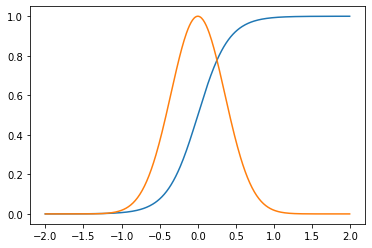

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from pymlutil.functions import Sigmoid, GaussianBasis
x = np.arange(-2.0, 2.0, 0.01) 
y1 = Sigmoid(x, scale = 1.0, offset=0.0, k_exp = 5.0)
plt.plot(x, y1)
y2 = GaussianBasis(torch.tensor(x), sigma=0.5)
plt.plot(x, y2)
plt.show()

6 July 2022
- Removed batch norm layers from UNET
- Training and pruning results were at least as good to network with batch norm
- No clear advantage provided by batch norm for weight magnitude from impacting relaxation magnitude
- crisplit_20220630i0_train
    ```yaml
    cross_entropy_loss: 0.0030129256192594767 
    test: 
        similarity: 
            0: 0.9977446895166078 
            1: 0.8221591634441512 
        average time: 0.003201360332294909 
        miou: 0.9099519264803795 
        num images: 963
    ```
- crisplit_20220630i0_train-fine
    ```yaml
    cross_entropy_loss: 0.002983461134135723 
    architecture_loss: 0.005337885580956936 
    prune_loss: 0.1341208666563034 
    architecture_reduction: 0.05337885394692421 
    test: 
        similarity: 
            0: 0.9975066577436897 
            1: 0.8136417113713045 
        average time: 0.007769013499480788 
        miou: 0.9055741845574972 
        num images: 963
    ```
- crisplit_20220630i0_prune 
    ```yaml
    prune: 
        final parameters: 593296 
        initial parameters: 31037517 
        remaining ratio: 0.019115446638337724 
    training: 
        cross_entropy_loss: 0.0037698952946811914 
    test: 
        similarity: 
            0: 0.9975929543526758 
            1: 0.8155541153342405 
        average time: 0.0032667279335410193 
        miou: 0.9065735348434582 
        num images: 963
    ```
- No full-layer collapse of UNET which may have caused a deviation between full and relaxed network

![crisplit_20220630i0_train-fine_cw.pn](../img/crisplit_20220630i0_train-fine_cw.png)
![crisplit_20220630i0_prune_cw.png](../img/crisplit_20220630i0_prune_cw.png)

- Architecture reduction never became 0
- Possibility of additional pruning while maintaining accuracy
- Prune loss continued to fall but with a falling rate
- Possibility of improved relaxation with increased time in train_fine
- increasing prune_basis did not appear to negatively impact architecture loss or cross_entropy loss
- How sloppy can I be with the prune_basis?  
- Can prune_basis be applied 100% throughout train_fine relaxation? 
- Would this slow architecture search?
- This would eliminate several parameters
- This would provide additional time to converge prune_loss
- When relaxation is removed, the scale factor is not applied to the convolution weights.
- If the convolution weight is 1 or 0, then there is a resulting shift that must be removed in post prune training
- Can post prune training be shortened or removed?
- Investigate changing prune epochs from 15 to 7 or 5
- Investigate converting sigmoid function to a fixed scale multiple

![crisplit_20220630i_tb.png](../img/crisplit_20220630i_tb.png)

### From literature review
- Can I demonstrate a linear reduction in time for structured pruning size reduction?
- This time reduction will need to adjust batch size to benefit from very heavy pruning.
- Can I demonstrate a different time reduction for unstructured pruning?
- Is this independent from other neural network optimizations: NAS, parameter optimization, quantization, target hardware optimization
- Structured pruning may be achieving similar compression ratios and accuracies as unstructured pruning.  
- If so, how?
- Quantify performance advantages of structured pruning
- What differences are there to the Lottery Ticket Hypothesis?
- Is there a more appropriate theoretical basis?
- Is there a theoretical basis independent of an approximation function?
- Are there any useful conclusions that can be made from this?
- Is the final pruning dependent on the initial state as is commonly assumed in the lottery ticket hypothesis
- What are the advantages/disadvantages of relaxation vs magnitude pruning?
- Explore simultaneous training/pruning
- Training/pruning from random variables
- Training/pruning from pretrained network
- Training/pruning from transfer learning
- How to speed pytorch training?  
- It seems much slower than Tensorflow training.  
- This may be due to FCN vs UNET not PyTorch vs Tensorflow or Tensorflow optimized data pipeline vs my Pytorch S3 data pulling.
- How robust is a pruned model in retraining?
- How robust is a pruned model to training in a new domain?
- Does the model converge to an equivalent solution?  
- How to deter




$$ \sigma(s) = \frac{1.0}{1.0+ e^{-k_1s}} $$

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from pymlutil.functions import Sigmoid, GaussianBasis
x = np.arange(-2.0, 2.0, 0.01) 
y1 = Sigmoid(x, scale = 1.0, offset=0.0, k_exp = 5.0)
plt.plot(x, y1)
plt.show()

$$ \delta(s) = e^{-\sqrt{\frac{s}{2*k_3}}} $$

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from pymlutil.functions import Sigmoid, GaussianBasis
x = np.arange(-2.0, 2.0, 0.01) 
y2 = GaussianBasis(torch.tensor(x), sigma=0.5)
plt.plot(x, y2)
plt.show()